In [22]:
#FIRST PART

#install beautiful soup and import bs4, pandas, urlopen
#!pip install bs4
import pandas as pd
import bs4
from urllib.request import urlopen
from bs4 import BeautifulSoup
from IPython.display import display, HTML

#Get the document
myurl = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
uclient = urlopen(myurl)
page_html = uclient.read()
uclient.close()

#parse in BeatifulSoup
bs=BeautifulSoup(page_html, "lxml")
table_body=bs.find('tbody')
datatext = table_body.find_all('td')
datatext = [x.text.strip() for x in datatext]

#Arrange the Pandas database neighborhood_data
df = pd.DataFrame(datatext)
neighborhood_data = pd.DataFrame({"Postal Code":[], "Borough":[], "Neighborhood":[]})

neighborhood_data["Postal Code"] = df[0].str[0:3]
neighborhood_data["Borough"] = df[0].str[3:]
neighborhood_data["Borough"] = neighborhood_data["Borough"].str.split("\(", n = 1, expand = True)

new = pd.DataFrame([])
new = df[0].str.split("\(", n = 1, expand = True)
new2 = new[1].str.split("\)", n = 1, expand = True)
neighborhood_data["Neighborhood"] = new2[0]

#filter out boroughs that are "Not assigned"
neighborhood_data = neighborhood_data[neighborhood_data.Borough != "Not assigned"]

#Replace "/" with ","
neighborhood_data["Neighborhood"] = neighborhood_data["Neighborhood"].str.replace(' /',',')

#Replace blanks in Neighbborhood column with value from Boroughs
neighborhood_data.loc[neighborhood_data["Neighborhood"].isnull(),'Neighborhood'] = neighborhood_data["Borough"]

#print the database
display(neighborhood_data)

print("The Number of Rows and Columns is:  ",neighborhood_data.shape)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


The Number of Rows and Columns is:   (103, 3)


In [23]:
#SECOND PART

#get the latitute and logitude
geospatialurl = "https://cocl.us/Geospatial_data"
uclient2 = urlopen(geospatialurl)
geospatial = pd.read_csv(uclient2)
uclient2.close()

#merge the dataframes
neighborhood_data2 = pd.merge(neighborhood_data, geospatial, on="Postal Code")

#print
display(neighborhood_data2)



,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [24]:
#neighborhood_data2.to_excel(r'C:\Users\User\Desktop\test2.xlsx',sheet_name= 'test2')

In [34]:
import json # library to handle JSON files
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.71, -79.3832], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhood_data2['Latitude'], neighborhood_data2['Longitude'], neighborhood_data2['Borough'], neighborhood_data2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

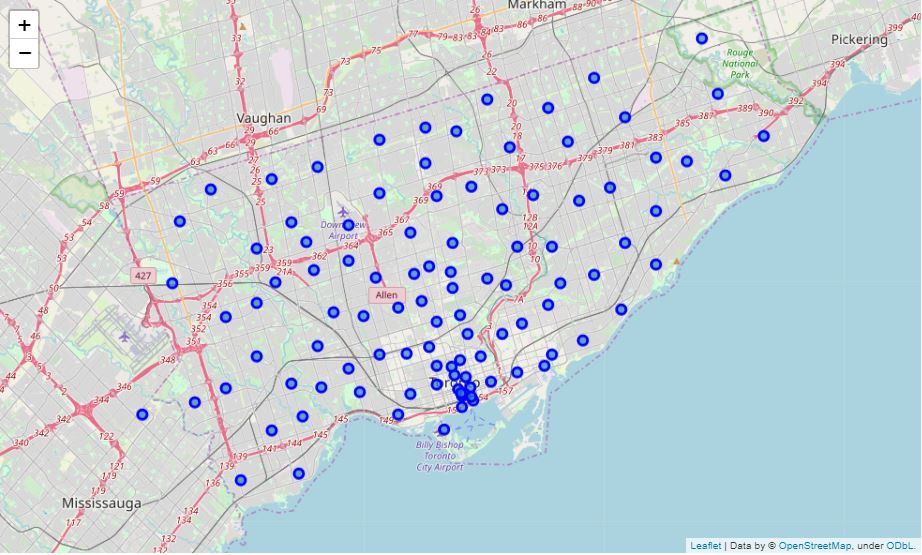

In [44]:
import requests
CLIENT_ID = 'LJ4MZEMRIA30N533Y4VHDSQ2WAKOCZHUAXBWG2PL3BBDZUYQ' # your Foursquare ID
CLIENT_SECRET = 'PK3HBQGUTSIJPDXJA3PI5NUXT5E5HRYN4NSR1WAQ3CK2E5IU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    43.71, 
    -79.3832, 
    radius, 
    LIMIT)
url # display URL


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_venues = getNearbyVenues(names=neighborhood_data2['Neighborhood'],
                                   latitudes=neighborhood_data2['Latitude'],
                                   longitudes=neighborhood_data2['Longitude']
                                  )

toronto_venues.groupby('Neighborhood').count()

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth W

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",11,11,11,11,11,11
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
Willowdale,40,40,40,40,40,40
Woburn,3,3,3,3,3,3
Woodbine Heights,9,9,9,9,9,9


In [50]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2               Skating Rink   0.2
3  Latin American Restaurant   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.18
1        Pharmacy  0.09
2             Gym  0.09
3  Sandwich Place  0.09
4    Skating Rink  0.09


----Bathurst Manor, Wilson Heights, Downsview North----
              venue  freq
0              Bank  0.10
1       Coffee Shop  0.10
2    Sandwich Place  0.05
3    Ice Cream Shop  0.05
4  Sushi Restaurant  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.12
1          Restaurant  0.08
2      Sandwich Place  0.08
3         Coffee Shop  0.

                 venue  freq
0          Pizza Place  0.08
1  American Restaurant  0.08
2         Liquor Store  0.08
3   Seafood Restaurant  0.08
4  Fried Chicken Joint  0.08


----North Park, Maple Leaf Park, Upwood Park----
                        venue  freq
0            Basketball Court  0.25
1                      Bakery  0.25
2  Construction & Landscaping  0.25
3                        Park  0.25
4                 Yoga Studio  0.00


----North Toronto West----
                 venue  freq
0          Coffee Shop  0.10
1       Clothing Store  0.10
2          Yoga Studio  0.05
3  Sporting Goods Shop  0.05
4       Cosmetics Shop  0.05


----Northwood Park, York University----
                  venue  freq
0        Massage Studio  0.14
1         Metro Station  0.14
2  Caribbean Restaurant  0.14
3                   Bar  0.14
4           Coffee Shop  0.14


----Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park Sout

In [52]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Clothing Store,Skating Rink,Lounge,Electronics Store,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dim Sum Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Sandwich Place,Gym,Coffee Shop,Skating Rink,Athletics & Sports,Dance Studio,Pub,Pool
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Supermarket,Pizza Place,Shopping Mall,Ice Cream Shop,Fried Chicken Joint,Frozen Yogurt Shop,Diner,Middle Eastern Restaurant
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Restaurant,Coffee Shop,Sandwich Place,Liquor Store,Butcher,Café,Sushi Restaurant,Pub,Fast Food Restaurant


In [119]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_, allow_duplicates=True)

toronto_merged = neighborhood_data2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged = toronto_merged.loc[:,~toronto_merged.columns.duplicated()]

toronto_merged = toronto_merged.dropna(subset=["Cluster Labels"])

toronto_merged.head() # check the last columns!



,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4.0,Park,Food & Drink Shop,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Portuguese Restaurant,Hockey Arena,French Restaurant,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Pub,Theater,Mexican Restaurant,Café,Restaurant,Bank,Ice Cream Shop
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Furniture / Home Store,Coffee Shop,Boutique,Miscellaneous Shop,Athletics & Sports,Women's Store,Event Space,Vietnamese Restaurant,Accessories Store
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,0.0,Coffee Shop,Park,Yoga Studio,Music Venue,Boutique,Seafood Restaurant,Sandwich Place,Burger Joint,Burrito Place,Café


In [118]:
# create map
map_clusters = folium.Map(location=[43.71, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

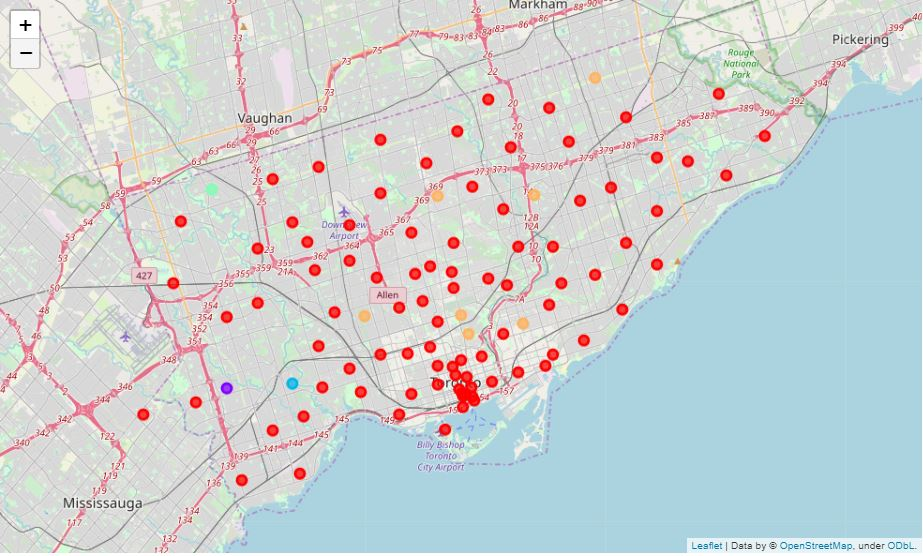

In [120]:
#toronto_merged.to_excel(r'C:\Users\User\Desktop\test2.xlsx',sheet_name= 'test2')

toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0.0,Portuguese Restaurant,Hockey Arena,French Restaurant,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
2,Downtown Toronto,0.0,Coffee Shop,Bakery,Park,Pub,Theater,Mexican Restaurant,Café,Restaurant,Bank,Ice Cream Shop
3,North York,0.0,Clothing Store,Furniture / Home Store,Coffee Shop,Boutique,Miscellaneous Shop,Athletics & Sports,Women's Store,Event Space,Vietnamese Restaurant,Accessories Store
4,Queen's Park / Ontario Provincial Government,0.0,Coffee Shop,Park,Yoga Studio,Music Venue,Boutique,Seafood Restaurant,Sandwich Place,Burger Joint,Burrito Place,Café
6,Scarborough,0.0,Fast Food Restaurant,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
...,...,...,...,...,...,...,...,...,...,...,...,...
97,Downtown Toronto,0.0,Coffee Shop,Café,Restaurant,Japanese Restaurant,American Restaurant,Hotel,Steakhouse,Gym,Asian Restaurant,Seafood Restaurant
99,Downtown Toronto,0.0,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Hotel,Pub,Bubble Tea Shop,Café,Men's Store
100,East TorontoBusiness reply mail Processing Cen...,0.0,Yoga Studio,Auto Workshop,Pizza Place,Comic Shop,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park,Spa
101,Etobicoke,0.0,Baseball Field,Construction & Landscaping,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [121]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Etobicoke,1.0,Golf Course,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


In [122]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,Etobicoke,2.0,River,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store,Deli / Bodega


In [123]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,North York,3.0,Pizza Place,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run


In [124]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,4.0,Park,Food & Drink Shop,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
21,York,4.0,Park,Women's Store,Market,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
35,East YorkEast Toronto,4.0,Convenience Store,Park,Metro Station,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
66,North York,4.0,Park,Convenience Store,Bank,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
83,Central Toronto,4.0,Park,Trail,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
85,Scarborough,4.0,Playground,Park,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
91,Downtown Toronto,4.0,Park,Trail,Playground,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [ ]:
#We see that the biggest cluster of popular venues is in downtown Toronto.  The cluster is restaurants and coffee shops.  
#So, the people of Toronto like to eat and like to drink coffee!
#Outside of the downtown area, there are more parks and playgrounds